In [1]:
# Libraries and dependencies
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.distributions as distributions
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Training environment (wind disabled)
env = gym.make(
    "LunarLander-v3",
    continuous=False,     
    gravity=-10.0,        
    enable_wind=False,   
    wind_power=15.0,      
    turbulence_power=1.0, 
    render_mode="rgb_array" 
)

# Evaluation environment (wind enabled)
video_env = gym.make(
    "LunarLander-v3",
    continuous=False,     
    gravity=-10.0,        
    enable_wind=False,   
    wind_power=15.0,      
    turbulence_power=1.0, 
    render_mode="rgb_array" 
)

# Record video every 100 epochs
video_env = RecordVideo(video_env, video_folder="ppo_500k_64_2048_3e4", episode_trigger=lambda x: x % 1000 == 0)   

In [3]:
space_dim = env.observation_space.shape[0]      # Observation space: 8-dimensional vector
action_dim = env.action_space.n                 # Action space: 4 discrete actions

# Training parameters (following paper)
gamma = 0.99                # Discount factor
lr = 3e-4                   # Learning rate
lamb = 0.95                 # Generalised Advantage Estimation (GAE) lambda
epsilon = 0.2               # Clipping value
h = 0.01                    # Entropy coefficient
v = 0.5                     # Value loss coefficient
max_timesteps = 500000      # Maximal number of iterations
eval_episodes = 100         # Episodes for evaluation
N = 1                       # Number of agents collecting training data
T = 2048                    # Maximal trajectory length
K = 10                      # Number of epoches per update
minibatch_size = 64         # Size of a mini batch
number_minibatches = N * T / minibatch_size     # Number of mini batches
actor_losses = []           # For plotting
critic_losses = []
eval_rewards = []            
index = []

In [4]:
# The network to select an action
ActorNetwork = nn.Sequential(
    nn.Linear(space_dim, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, action_dim)
)

# The network to get value of a state
CriticNetwork = nn.Sequential(
    nn.Linear(space_dim, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 1)
)

# Optimizer using Adam Gradient Descent
actor_optimizer = optim.Adam(ActorNetwork.parameters(), lr=lr)
critic_optimizer = optim.Adam(CriticNetwork.parameters(), lr=lr)

In [5]:
def evaluation(eval_episodes):
    total_reward = 0
    for _ in range(eval_episodes):
        episode_reward = 0
        state, _ = video_env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state)
            action_pred = ActorNetwork(state_tensor)
            action = torch.argmax(action_pred).item()
            state, reward, terminated, truncated, _ = video_env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_reward += episode_reward
    return total_reward / eval_episodes     

In [6]:
def select_action(state_tensor):
    value = CriticNetwork(state_tensor)
    action_pred = ActorNetwork(state_tensor)                    
    dist = distributions.Categorical(logits=action_pred)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    return action, value, log_prob

In [7]:
def collect_training_data(state, action, reward, log_prob, value, done, states, actions, rewards, log_probs, values, dones):
    states.append(state)         # Collect states
    actions.append(action)        # Collect actions from Actor Network
    rewards.append(reward)        # Collect rewards
    log_probs.append(log_prob)      # Collect lob_probs
    values.append(value)         # Collect values from Critic Network
    dones.append(done)          # Collect done (0 or 1)

In [8]:
def compute_GAE(next_value, rewards, values, dones):
    advantages = []
    GAE = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * next_value * (1 - dones[t]) - values[t]      # TD error
        GAE = delta + gamma * lamb * (1 - dones[t]) * GAE
        advantages.insert(0, GAE)
        next_value = values[t].item()
    return advantages

In [9]:
def compute_advantages(next_state_tensor: torch.Tensor, rewards: list, values: list, dones: list):
    next_value = CriticNetwork(next_state_tensor)                                           # Calculate the next value
    advantages = compute_GAE(next_value, rewards=rewards, values=values, dones=dones)       # Calculate advantage using GAE
    advantages = torch.FloatTensor(advantages)              
    return advantages

In [10]:
def get_parameterized_policy(batch_states, batch_actions):
    optimized_value = CriticNetwork(batch_states)
    optimized_action_preds = ActorNetwork(batch_states)
    optimized_dist = distributions.Categorical(logits=optimized_action_preds)
    optimized_log_probs = optimized_dist.log_prob(batch_actions)

    return optimized_value, optimized_dist, optimized_log_probs

In [11]:
def calculate_clipped_surrogate_loss(batch_old_log_probs, batch_returns, batch_advantages, optimized_value, optimized_dist, optimized_log_probs):
    ratio = (optimized_log_probs - batch_old_log_probs).exp()                                   # Ratio = divergence between old and current policy
    unclipped_objective = ratio * batch_advantages                                              # The unclipped part
    clipped_objective = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * batch_advantages         # The clipped part: Clip the ratio to range [1 - ε, 1 + ε]

    L_clip = -torch.min(unclipped_objective, clipped_objective).mean()          # Take the smaller part
    L_v = (optimized_value.squeeze() - batch_returns).pow(2).mean()             # Squared-error value loss
    H_entropy = optimized_dist.entropy().mean()                                 # Entropy bonus: Ensure sufficient exploration

    return L_clip, L_v, H_entropy

In [12]:
state, _ = env.reset()      # Initialize state s_t
timesteps = 0

while timesteps < max_timesteps:
    states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
    print(timesteps)

    for _ in range(T):              # Collect T timesteps for 1 rollout
        action, value, log_prob = select_action(torch.FloatTensor(state)) # Get action a_t, value V(s)_t, and old policy given action a_t

        next_state, reward, terminated, truncated, _ = env.step(action.item())      # Advance simulation one time step
        done = terminated or truncated

        # Collect training data
        collect_training_data(state, action, reward, log_prob, value, done, states, actions, rewards, log_probs, values, dones)  

        state = next_state      # Move to next state
        timesteps += 1          # Increase timesteps

        if done:
            state, _ = env.reset()      # If an episode is done, reset the state
    
    # Compute advantages
    advantages = compute_advantages(next_state_tensor=torch.FloatTensor(state), rewards=rewards, values=values, dones=dones)     # Calculate advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)               # Normalize advantages
    returns = advantages + torch.FloatTensor(values)        # Calculate V-target_t = A_t + V-w(s_t)

    # Convert data for training 
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    old_log_probs = torch.FloatTensor(log_probs)
    returns = returns.detach()

    # Optimizing the surrogate loss
    for k in range(K):          
        for i in torch.randperm(len(states)).split(minibatch_size):        # Sample over batches with size 'minibatch_size'      
            batch_states = states[i]
            batch_actions = actions[i]
            batch_old_log_probs = old_log_probs[i]
            batch_returns = returns[i]
            batch_advantages = advantages[i]

            optimized_value, optimized_dist, optimized_log_probs = get_parameterized_policy(batch_states=batch_states, batch_actions=batch_actions)
        
            L_clip, L_v, H_entropy = calculate_clipped_surrogate_loss(batch_old_log_probs, batch_returns, batch_advantages, optimized_value, optimized_dist, optimized_log_probs)

            # Loss = L_clip + v * L_v - h * H_entropy

            # Actor loss
            actor_loss = L_clip - h * H_entropy
            actor_losses.append(actor_loss.item())
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Critic loss
            critic_loss = L_v * v
            critic_losses.append(critic_loss.item())
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

    if timesteps % T == 0:
        try:
            avg_rewards = evaluation(eval_episodes)
            print(f"In current timestep: {timesteps}, average reward: {avg_rewards}", flush=True)
            index.append(timesteps)
            eval_rewards.append(avg_rewards)
        except Exception as e:
            print(f"Error in evaluation: {e}", flush=True)
        


0


C:\Users\NguyenThanh\AppData\Local\Temp\ipykernel_15008\3801592811.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.FloatTensor(states)


In current timestep: 2048, average reward: -574.3856242776917
2048
In current timestep: 4096, average reward: -546.091907360471
4096
In current timestep: 6144, average reward: -563.0235894837383
6144
In current timestep: 8192, average reward: -811.8338871235999
8192
In current timestep: 10240, average reward: -748.4626630783731
10240
In current timestep: 12288, average reward: -350.8911787232064
12288
In current timestep: 14336, average reward: -382.99814897496725
14336
In current timestep: 16384, average reward: -285.0013358748228
16384
In current timestep: 18432, average reward: -330.7358719321424
18432
In current timestep: 20480, average reward: -236.4966148314465
20480
In current timestep: 22528, average reward: -198.96729803551818
22528
In current timestep: 24576, average reward: -192.94048557546492
24576
In current timestep: 26624, average reward: -213.77079186402963
26624
In current timestep: 28672, average reward: -210.55309570376536
28672
In current timestep: 30720, average re

In [13]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

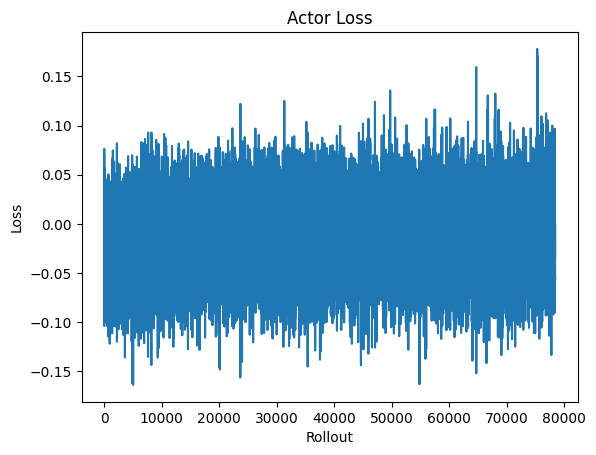

In [14]:
plt.plot(moving_average(actor_losses))
plt.title("Actor Loss")
plt.xlabel("Rollout")
plt.ylabel("Loss")
plt.show()

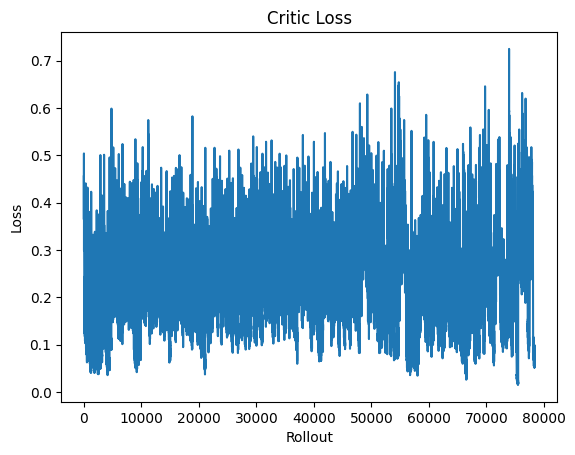

In [15]:
plt.plot(moving_average(critic_losses))
plt.title("Critic Loss")
plt.xlabel("Rollout")
plt.ylabel("Loss")
plt.show()

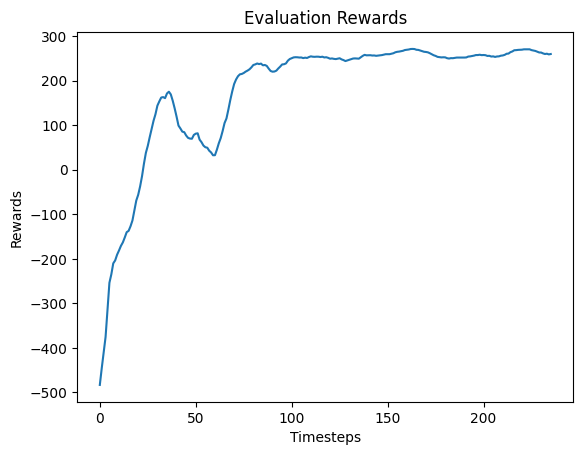

In [18]:
plt.plot(moving_average(eval_rewards))
plt.title("Evaluation Rewards")
plt.xlabel("Timesteps")
plt.ylabel("Rewards")
plt.show()